In [4]:
"""
Fire Severity and Elevation Analysis Module

Analyzes wildfire burn severity using Landsat NBR and correlates with elevation data.

Functions:
- clean_fire_year(): Converts fire year values to integers
- load_and_select_fire(): Load fire data and select specific fire for analysis
- search_landsat_imagery(): Search for Landsat images around target date  
- search_with_expanding_dates(): Search with progressively wider date ranges
- calculate_landsat_nbr(): Compute NBR from Landsat NIR and SWIR2 bands
- get_elevation_data(): Download elevation data using OpenTopoData API
- analyze_fire_severity_elevation(): Correlate fire severity with elevation
- plot_elevation_analysis(): Create comprehensive visualization plots
- run_fire_elevation_analysis(): Main workflow function

Usage:
    results = run_fire_elevation_analysis(geojson_path, target_year=1989)
"""

import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.interpolate import griddata
import requests
import time
import warnings
warnings.filterwarnings('ignore')


def clean_fire_year(year_value):
    """Convert fire year to integer, handling various formats."""
    try:
        if pd.isna(year_value):
            return None
        year_str = str(year_value)
        if '-' in year_str:
            return int(year_str.split('-')[0])
        return int(float(year_str))
    except (ValueError, TypeError):
        return None


def load_and_select_fire(geojson_path, target_year=1989, fire_index=0):
    """Load fire data and select a specific fire for analysis."""
    import os
    
    print("Loading fire data...")
    
    # Check if file exists
    if not os.path.exists(geojson_path):
        print(f"Error: File not found at {geojson_path}")
        print("Please check the file path. Common locations:")
        print("  - './fires.geojson' (current directory)")
        print("  - '../data/fires.geojson' (data folder one level up)")
        print("  - '/path/to/your/fires.geojson' (absolute path)")
        raise FileNotFoundError(f"Fire data file not found: {geojson_path}")
    
    try:
        fires = gpd.read_file(geojson_path)
        print(f"Successfully loaded {len(fires)} fire records")
    except Exception as e:
        print(f"Error reading fire data: {e}")
        raise
    
    # Clean fire year data
    fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
    fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
    fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)
    
    print(f"Available years: {sorted(fires_clean['FIRE_YEAR_CLEAN'].unique())}")
    
    # Filter for target year
    target_fires = fires_clean[fires_clean['FIRE_YEAR_CLEAN'] == target_year].copy()
    
    if len(target_fires) == 0:
        print(f"No fires found for {target_year}, trying nearby years...")
        for test_year in [target_year-1, target_year+1, target_year-2, target_year+2]:
            test_fires = fires_clean[fires_clean['FIRE_YEAR_CLEAN'] == test_year]
            if len(test_fires) > 0:
                print(f"Using {test_year} fires ({len(test_fires)} available)")
                target_fires = test_fires.copy()
                target_year = test_year
                break
    
    if len(target_fires) == 0:
        raise ValueError(f"No fires found near year {target_year}")
    
    # Convert to WGS84 and select fire
    target_fires_wgs84 = target_fires.to_crs('EPSG:4326')
    
    print(f"Available fires for {target_year}:")
    for i, (idx, fire) in enumerate(target_fires_wgs84.iterrows()):
        fire_name = fire.get('INCIDENT', f'Fire_{i}')
        fire_id = fire.get('UNQE_FIRE_', f'ID_{i}')
        area = fire.geometry.area
        print(f"  {i}: {fire_name} ({fire_id}) - Area: {area:.8f} sq deg")
    
    if fire_index >= len(target_fires_wgs84):
        fire_index = 0
        print(f"Requested index {fire_index} not available, using fire 0")
    
    selected_fire = target_fires_wgs84.iloc[fire_index]
    
    fire_info = {
        'geometry': selected_fire.geometry,
        'fire_id': selected_fire.get("UNQE_FIRE_", "unknown"),
        'incident_name': selected_fire.get("INCIDENT", "Unknown Fire"),
        'fire_year': int(selected_fire["FIRE_YEAR_CLEAN"]),
        'index': fire_index
    }
    
    print(f"\nSelected Fire: {fire_info['incident_name']} ({fire_info['fire_id']})")
    print(f"Year: {fire_info['fire_year']}")
    print(f"Area: {fire_info['geometry'].area:.8f} square degrees")
    
    return fire_info


def search_landsat_imagery(geometry, target_date, days_buffer=60, platform="landsat-5"):
    """Search for Landsat imagery around target date."""
    start_date = (target_date - timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    end_date = (target_date + timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    
    print(f"Searching {platform.upper()} imagery from {start_date} to {end_date}")
    
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1/",
        modifier=pc.sign_inplace
    )
    
    bounds = geometry.bounds
    bbox = [bounds[0], bounds[1], bounds[2], bounds[3]]
    
    search = catalog.search(
        collections=["landsat-c2-l2"],
        bbox=bbox,
        datetime=f"{start_date}/{end_date}",
        query={
            "platform": {"in": [platform]},
            "eo:cloud_cover": {"lt": 50}
        }
    )
    
    items = list(search.items())
    
    if len(items) == 0:
        print("No images found with cloud filter, trying without...")
        search = catalog.search(
            collections=["landsat-c2-l2"],
            bbox=bbox,
            datetime=f"{start_date}/{end_date}",
            query={"platform": {"in": [platform]}}
        )
        items = list(search.items())
    
    if len(items) > 0:
        items_with_info = []
        for item in items:
            cloud_cover = item.properties.get('eo:cloud_cover', 100)
            item_date = pd.to_datetime(item.properties['datetime'])
            
            if item_date.tz is not None:
                item_date = item_date.tz_localize(None)
            if hasattr(target_date, 'tz') and target_date.tz is not None:
                target_date = target_date.tz_localize(None)
            
            date_diff = abs((item_date - target_date).days)
            items_with_info.append((item, cloud_cover, date_diff, item_date.strftime('%Y-%m-%d')))
        
        items_with_info.sort(key=lambda x: (x[2], x[1]))
        sorted_items = [item for item, cloud, date_diff, date_str in items_with_info]
        
        print(f"Found {len(sorted_items)} images")
        for i, (item, cloud, date_diff, date_str) in enumerate(items_with_info[:3]):
            print(f"  Image {i+1}: {date_str}, {cloud:.1f}% clouds, {date_diff} days from target")
        
        return sorted_items
    else:
        print("No images found")
        return []


def search_with_expanding_dates(geometry, target_date, platform="landsat-5"):
    """Search with progressively expanding date ranges."""
    buffers = [30, 60, 120, 240, 365]
    
    for attempt, buffer in enumerate(buffers):
        print(f"Attempt {attempt + 1}: Searching with +/-{buffer} day buffer...")
        items = search_landsat_imagery(geometry, target_date, days_buffer=buffer, platform=platform)
        
        if len(items) > 0:
            return items
            
        if attempt < len(buffers) - 1:
            print("No results, expanding search window...")
    
    print(f"No {platform.upper()} imagery found")
    return []


def calculate_landsat_nbr(item, fire_polygon, satellite="landsat-5"):
    """Calculate NBR from Landsat data, clipped to fire boundary."""
    try:
        signed_item = pc.sign(item)
        
        print(f"Processing {satellite.upper()} image from: {item.properties.get('datetime', 'Unknown')}")
        print(f"Cloud cover: {item.properties.get('eo:cloud_cover', 'Unknown')}%")
        
        # Define band mappings for different Landsat satellites
        band_mapping = {
            "landsat-5": {"nir": "nir08", "swir2": "swir22"},
            "landsat-7": {"nir": "nir08", "swir2": "swir22"},
            "landsat-8": {"nir": "nir08", "swir2": "swir22"},
            "landsat-9": {"nir": "nir08", "swir2": "swir22"}
        }
        
        bands = band_mapping.get(satellite, band_mapping["landsat-5"])
        nir_band = bands["nir"]
        swir2_band = bands["swir2"]
        
        # Check if bands exist
        available_assets = list(signed_item.assets.keys())
        if nir_band not in available_assets or swir2_band not in available_assets:
            print(f"Required bands not found. Need: {nir_band}, {swir2_band}")
            return None
        
        print(f"Using NIR: {nir_band}, SWIR2: {swir2_band}")
        
        # Load bands
        nir = rxr.open_rasterio(signed_item.assets[nir_band].href, chunks={'x': 1024, 'y': 1024})
        swir2 = rxr.open_rasterio(signed_item.assets[swir2_band].href, chunks={'x': 1024, 'y': 1024})
        
        # Convert fire polygon to raster CRS and crop
        temp_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
        fire_proj = temp_gdf.to_crs(nir.rio.crs).geometry.iloc[0]
        bounds = fire_proj.bounds
        crop_buffer = 2000
        
        try:
            nir_cropped = nir.rio.clip_box(
                minx=bounds[0] - crop_buffer, miny=bounds[1] - crop_buffer,
                maxx=bounds[2] + crop_buffer, maxy=bounds[3] + crop_buffer
            )
            swir2_cropped = swir2.rio.clip_box(
                minx=bounds[0] - crop_buffer, miny=bounds[1] - crop_buffer,
                maxx=bounds[2] + crop_buffer, maxy=bounds[3] + crop_buffer
            )
        except:
            print("Cropping failed, using original extent")
            nir_cropped = nir
            swir2_cropped = swir2
        
        # Apply Landsat Collection 2 scaling
        nir_scaled = nir_cropped * 0.0000275 - 0.2
        swir2_scaled = swir2_cropped * 0.0000275 - 0.2
        
        # Ensure same resolution
        if nir_scaled.shape != swir2_scaled.shape:
            swir2_scaled = swir2_scaled.rio.reproject_match(nir_scaled)
        
        # Calculate NBR
        nbr = (nir_scaled - swir2_scaled) / (nir_scaled + swir2_scaled)
        nbr = nbr.where((nir_scaled + swir2_scaled) != 0)
        
        # Clip to fire boundary
        nbr_fire_only = nbr.rio.clip([fire_proj], crs=nbr.rio.crs, drop=True, all_touched=True)
        
        # Check results
        valid_pixels = (~np.isnan(nbr_fire_only.values)).sum()
        total_pixels = nbr_fire_only.size
        
        print(f"Valid pixels: {valid_pixels}/{total_pixels} ({100*valid_pixels/total_pixels:.1f}%)")
        
        if valid_pixels == 0:
            print("No valid data within fire boundary")
            return None
        
        print("NBR calculated successfully")
        return nbr_fire_only
        
    except Exception as e:
        print(f"Error calculating NBR: {e}")
        return None


def get_elevation_data(fire_geometry, buffer_meters=5000):
    """Get elevation data using OpenTopoData API."""
    print("Downloading elevation data...")
    
    # Get bounds with buffer
    fire_utm = fire_geometry.to_crs('EPSG:3857')
    buffered = fire_utm.buffer(buffer_meters)
    buffered_wgs84 = buffered.to_crs('EPSG:4326')
    bounds = buffered_wgs84.bounds
    if hasattr(bounds, 'iloc'):
        bounds = bounds.iloc[0]
    
    try:
        # Create grid of points for elevation sampling
        lat_points = np.linspace(bounds[1], bounds[3], 25)
        lon_points = np.linspace(bounds[0], bounds[2], 25)
        
        elevations = []
        locations = []
        
        # Sample elevation at grid points
        for i, lat in enumerate(lat_points):
            for j, lon in enumerate(lon_points):
                url = f"https://api.opentopodata.org/v1/srtm30m?locations={lat},{lon}"
                try:
                    response = requests.get(url, timeout=10)
                    if response.status_code == 200:
                        data = response.json()
                        if data['status'] == 'OK' and len(data['results']) > 0:
                            elev = data['results'][0]['elevation']
                            if elev is not None:
                                elevations.append(elev)
                                locations.append((lon, lat))
                except:
                    continue
                
                time.sleep(0.05)  # Rate limiting
            
            if i % 5 == 0:
                print(f"  Downloaded {len(elevations)} elevation points...")
        
        if len(elevations) > 20:
            print(f"Retrieved {len(elevations)} elevation points")
            
            # Interpolate to create grid
            target_lats = np.linspace(bounds[1], bounds[3], 150)
            target_lons = np.linspace(bounds[0], bounds[2], 150)
            target_lon_grid, target_lat_grid = np.meshgrid(target_lons, target_lats)
            
            points = np.array(locations)
            values = np.array(elevations)
            
            interpolated = griddata(points, values, (target_lon_grid, target_lat_grid), method='cubic')
            
            # Fill NaN values with nearest neighbor
            if np.isnan(interpolated).any():
                interpolated_nn = griddata(points, values, (target_lon_grid, target_lat_grid), method='nearest')
                interpolated = np.where(np.isnan(interpolated), interpolated_nn, interpolated)
            
            # Create xarray dataset
            elevation = xr.DataArray(
                interpolated,
                coords={'y': target_lats, 'x': target_lons},
                dims=['y', 'x']
            ).rio.write_crs('EPSG:4326')
            
            print(f"Created elevation grid: {elevation.shape}")
            print(f"Elevation range: {float(elevation.min().values):.0f}m to {float(elevation.max().values):.0f}m")
            return elevation
            
        else:
            print(f"Only retrieved {len(elevations)} points, not enough for analysis")
            return None
            
    except Exception as e:
        print(f"Error downloading elevation data: {e}")
        return None


def analyze_fire_severity_elevation(dnbr, elevation, fire_geometry):
    """Analyze relationship between fire severity (dNBR) and elevation."""
    print("Analyzing fire severity vs elevation relationship...")
    
    # Ensure both datasets have same CRS
    if dnbr.rio.crs != elevation.rio.crs:
        elevation = elevation.rio.reproject_match(dnbr)
    
    # Clip both datasets to fire boundary
    fire_proj = gpd.GeoDataFrame([1], geometry=[fire_geometry], crs='EPSG:4326')
    fire_proj = fire_proj.to_crs(dnbr.rio.crs)
    
    dnbr_fire = dnbr.rio.clip(fire_proj.geometry, drop=True, all_touched=True)
    elevation_fire = elevation.rio.clip(fire_proj.geometry, drop=True, all_touched=True)
    
    if dnbr_fire.shape != elevation_fire.shape:
        elevation_fire = elevation_fire.rio.reproject_match(dnbr_fire)
    
    # Flatten and clean data
    dnbr_values = dnbr_fire.values.flatten()
    elev_values = elevation_fire.values.flatten()
    
    valid_mask = ~(np.isnan(dnbr_values) | np.isnan(elev_values))
    dnbr_clean = dnbr_values[valid_mask]
    elev_clean = elev_values[valid_mask]
    
    if len(dnbr_clean) == 0:
        print("No overlapping valid data")
        return None
    
    print(f"Analyzing {len(dnbr_clean)} valid pixels")
    
    # Calculate statistics
    correlation, p_value = stats.pearsonr(dnbr_clean, elev_clean)
    
    # Elevation binning analysis
    n_bins = 8
    elev_bins = np.linspace(elev_clean.min(), elev_clean.max(), n_bins + 1)
    elev_centers = (elev_bins[:-1] + elev_bins[1:]) / 2
    
    severity_by_elevation = []
    
    for i in range(n_bins):
        mask = (elev_clean >= elev_bins[i]) & (elev_clean < elev_bins[i + 1])
        if i == n_bins - 1:
            mask = (elev_clean >= elev_bins[i]) & (elev_clean <= elev_bins[i + 1])
        
        if np.sum(mask) > 0:
            bin_dnbr = dnbr_clean[mask]
            
            high_sev = np.sum(bin_dnbr > 0.66) / len(bin_dnbr) * 100
            mod_high_sev = np.sum((bin_dnbr >= 0.44) & (bin_dnbr <= 0.66)) / len(bin_dnbr) * 100
            mod_low_sev = np.sum((bin_dnbr >= 0.25) & (bin_dnbr < 0.44)) / len(bin_dnbr) * 100
            low_sev = np.sum((bin_dnbr >= 0.1) & (bin_dnbr < 0.25)) / len(bin_dnbr) * 100
            unburned = np.sum(bin_dnbr < 0.1) / len(bin_dnbr) * 100
            
            severity_by_elevation.append({
                'elevation': elev_centers[i],
                'high_severity': high_sev,
                'moderate_high': mod_high_sev,
                'moderate_low': mod_low_sev,
                'low_severity': low_sev,
                'unburned': unburned,
                'mean_dnbr': np.mean(bin_dnbr),
                'pixel_count': len(bin_dnbr)
            })
    
    results = {
        'dnbr_values': dnbr_clean,
        'elevation_values': elev_clean,
        'correlation': correlation,
        'p_value': p_value,
        'elevation_bins': elev_centers,
        'severity_by_elevation': pd.DataFrame(severity_by_elevation)
    }
    
    return results


def plot_elevation_analysis(results, fire_name="Fire"):
    """Create comprehensive plots of fire severity vs elevation."""
    fig = plt.figure(figsize=(16, 10))
    
    # Scatter plot with trend line
    ax1 = plt.subplot(2, 3, 1)
    plt.scatter(results['elevation_values'], results['dnbr_values'], 
                alpha=0.5, s=2, c='red')
    
    z = np.polyfit(results['elevation_values'], results['dnbr_values'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(results['elevation_values'].min(), 
                         results['elevation_values'].max(), 100)
    plt.plot(x_trend, p(x_trend), 'blue', linewidth=2, alpha=0.8)
    
    plt.xlabel('Elevation (m)')
    plt.ylabel('dNBR')
    plt.title(f'Fire Severity vs Elevation\nr = {results["correlation"]:.3f}, p = {results["p_value"]:.4f}')
    plt.grid(True, alpha=0.3)
    
    # Mean dNBR by elevation
    ax2 = plt.subplot(2, 3, 2)
    severity_df = results['severity_by_elevation']
    plt.plot(severity_df['elevation'], severity_df['mean_dnbr'], 
             'o-', linewidth=2, markersize=8, color='darkred')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Mean dNBR')
    plt.title('Mean Fire Severity by Elevation')
    plt.grid(True, alpha=0.3)
    
    # Stacked bar chart
    ax3 = plt.subplot(2, 3, 3)
    x_pos = np.arange(len(severity_df))
    
    plt.bar(x_pos, severity_df['high_severity'], label='High (>0.66)', color='darkred')
    plt.bar(x_pos, severity_df['moderate_high'], 
            bottom=severity_df['high_severity'], label='Mod-High (0.44-0.66)', color='red')
    plt.bar(x_pos, severity_df['moderate_low'], 
            bottom=severity_df['high_severity'] + severity_df['moderate_high'], 
            label='Mod-Low (0.25-0.44)', color='orange')
    plt.bar(x_pos, severity_df['low_severity'], 
            bottom=severity_df['high_severity'] + severity_df['moderate_high'] + severity_df['moderate_low'], 
            label='Low (0.1-0.25)', color='yellow')
    plt.bar(x_pos, severity_df['unburned'],
            bottom=severity_df['high_severity'] + severity_df['moderate_high'] + 
                   severity_df['moderate_low'] + severity_df['low_severity'],
            label='Unburned (<0.1)', color='green')
    
    plt.xlabel('Elevation Bin')
    plt.ylabel('Percentage')
    plt.title('Burn Severity by Elevation')
    plt.xticks(x_pos, [f"{elev:.0f}m" for elev in severity_df['elevation']], rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Elevation histogram
    ax4 = plt.subplot(2, 3, 4)
    plt.hist(results['elevation_values'], bins=30, alpha=0.7, color='brown', edgecolor='black')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Pixels')
    plt.title('Elevation Distribution')
    plt.grid(True, alpha=0.3)
    
    # dNBR histogram
    ax5 = plt.subplot(2, 3, 5)
    plt.hist(results['dnbr_values'], bins=30, alpha=0.7, color='red', edgecolor='black')
    plt.xlabel('dNBR')
    plt.ylabel('Pixels')
    plt.title('dNBR Distribution')
    plt.grid(True, alpha=0.3)
    
    # Summary statistics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    corr_abs = abs(results['correlation'])
    strength = "Strong" if corr_abs > 0.7 else "Moderate" if corr_abs > 0.3 else "Weak"
    direction = "positive" if results['correlation'] > 0 else "negative"
    significance = "significant" if results['p_value'] < 0.05 else "not significant"
    
    summary_text = f"""ELEVATION ANALYSIS SUMMARY

Fire: {fire_name}
Pixels: {len(results['dnbr_values']):,}

Elevation:
• Range: {results['elevation_values'].min():.0f} - {results['elevation_values'].max():.0f} m
• Mean: {results['elevation_values'].mean():.0f} m

dNBR:
• Range: {results['dnbr_values'].min():.3f} - {results['dnbr_values'].max():.3f}
• Mean: {results['dnbr_values'].mean():.3f}

Correlation:
• r = {results['correlation']:.4f}
• p = {results['p_value']:.6f}
• {strength} {direction} correlation
• {significance} (α=0.05)"""
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle(f'{fire_name} - Fire Severity vs Elevation Analysis', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


def find_fire_data():
    """Helper function to find fire data file in common locations."""
    import os
    
    common_paths = [
        'fires.geojson',
        './fires.geojson', 
        '../data/fires.geojson',
        '../downloaded_data/mnf_fires_all.geojson',
        './data/fires.geojson',
        './mnf_fires_all.geojson'
    ]
    
    print("Searching for fire data file...")
    for path in common_paths:
        if os.path.exists(path):
            print(f"Found fire data at: {path}")
            return path
    
    print("Fire data file not found in common locations:")
    for path in common_paths:
        print(f"  - {path}")
    
    return None


def run_fire_elevation_analysis(geojson_path=None, target_year=1989, fire_index=0, satellite="landsat-5"):
    """Complete workflow: Load fire, calculate dNBR, analyze with elevation."""
    
    print("FIRE SEVERITY + ELEVATION ANALYSIS")
    print("="*50)
    
    # Try to find fire data if path not provided
    if geojson_path is None:
        geojson_path = find_fire_data()
        if geojson_path is None:
            print("\nPlease provide the path to your fire data file:")
            print("run_fire_elevation_analysis('/path/to/your/fire_data.geojson')")
            return None
    
    # Load and select fire
    fire_info = load_and_select_fire(geojson_path, target_year, fire_index)
    
    # Define analysis dates
    fire_year = fire_info['fire_year']
    pre_fire_date = pd.to_datetime(f"{fire_year}-04-15")
    post_fire_date = pd.to_datetime(f"{fire_year + 1}-07-01")
    
    print(f"\nAnalysis Timeline:")
    print(f"Pre-fire: {pre_fire_date.strftime('%Y-%m-%d')}")
    print(f"Post-fire: {post_fire_date.strftime('%Y-%m-%d')}")
    print(f"Satellite: {satellite.upper()}")
    
    # Search for pre-fire imagery
    print(f"\nSearching for pre-fire imagery...")
    pre_fire_items = search_with_expanding_dates(fire_info['geometry'], pre_fire_date, satellite)
    
    if len(pre_fire_items) == 0:
        print("No pre-fire imagery found")
        return None
    
    # Calculate pre-fire NBR
    print(f"\nCalculating pre-fire NBR...")
    pre_fire_nbr = calculate_landsat_nbr(pre_fire_items[0], fire_info['geometry'], satellite)
    
    if pre_fire_nbr is None:
        print("Pre-fire NBR calculation failed")
        return None
    
    pre_stats = pre_fire_nbr.compute()
    print(f"Pre-fire NBR: Mean {float(pre_stats.mean().values):.3f}")
    
    # Search for post-fire imagery
    print(f"\nSearching for post-fire imagery...")
    post_fire_items = search_with_expanding_dates(fire_info['geometry'], post_fire_date, satellite)
    
    if len(post_fire_items) == 0:
        print("No post-fire imagery found")
        return None
    
    # Calculate post-fire NBR
    print(f"\nCalculating post-fire NBR...")
    post_fire_nbr = calculate_landsat_nbr(post_fire_items[0], fire_info['geometry'], satellite)
    
    if post_fire_nbr is None:
        print("Post-fire NBR calculation failed")
        return None
    
    post_stats = post_fire_nbr.compute()
    print(f"Post-fire NBR: Mean {float(post_stats.mean().values):.3f}")
    
    # Calculate dNBR
    print(f"\nCalculating dNBR...")
    
    if pre_fire_nbr.rio.crs != post_fire_nbr.rio.crs:
        post_fire_nbr = post_fire_nbr.rio.reproject_match(pre_fire_nbr)
    
    dnbr = pre_fire_nbr - post_fire_nbr
    
    # Calculate burn severity statistics
    dnbr_computed = dnbr.compute()
    dnbr_flat = dnbr_computed.values.flatten()
    dnbr_flat = dnbr_flat[~np.isnan(dnbr_flat)]
    
    if len(dnbr_flat) > 0:
        # Calculate severity classes
        high_severity = np.sum(dnbr_flat > 0.66)
        mod_high_severity = np.sum((dnbr_flat >= 0.44) & (dnbr_flat <= 0.66))
        mod_low_severity = np.sum((dnbr_flat >= 0.25) & (dnbr_flat < 0.44))
        low_severity = np.sum((dnbr_flat >= 0.1) & (dnbr_flat < 0.25))
        unburned = np.sum(dnbr_flat < 0.1)
        total_pixels = len(dnbr_flat)
        
        print(f"dNBR calculated successfully!")
        print(f"Mean dNBR: {np.mean(dnbr_flat):.3f}")
        print(f"Range: {np.min(dnbr_flat):.3f} to {np.max(dnbr_flat):.3f}")
        print(f"Total pixels: {total_pixels:,}")
        
        print(f"\nBurn Severity Classification:")
        print(f"High Severity (>0.66):      {high_severity:5d} pixels ({100*high_severity/total_pixels:5.1f}%)")
        print(f"Moderate-High (0.44-0.66):  {mod_high_severity:5d} pixels ({100*mod_high_severity/total_pixels:5.1f}%)")
        print(f"Moderate-Low (0.25-0.44):   {mod_low_severity:5d} pixels ({100*mod_low_severity/total_pixels:5.1f}%)")
        print(f"Low Severity (0.1-0.25):    {low_severity:5d} pixels ({100*low_severity/total_pixels:5.1f}%)")
        print(f"Unburned (<0.1):            {unburned:5d} pixels ({100*unburned/total_pixels:5.1f}%)")
    
    # Get elevation data
    print(f"\nDownloading elevation data...")
    fire_gdf = gpd.GeoDataFrame([1], geometry=[fire_info['geometry']], crs='EPSG:4326')
    elevation = get_elevation_data(fire_gdf, buffer_meters=3000)
    
    if elevation is None:
        print("Could not download elevation data")
        return None
    
    # Perform elevation analysis
    print(f"\nAnalyzing fire severity vs elevation...")
    elevation_results = analyze_fire_severity_elevation(dnbr, elevation, fire_info['geometry'])
    
    if elevation_results is None:
        print("Elevation analysis failed")
        return None
    
    # Create visualizations
    print(f"\nCreating visualizations...")
    fire_display_name = f"{fire_info['incident_name']} ({fire_year})"
    plot_elevation_analysis(elevation_results, fire_display_name)
    
    # Print detailed results
    print(f"\nFINAL ANALYSIS RESULTS")
    print("="*30)
    
    print(f"\nFire Information:")
    print(f"Name: {fire_info['incident_name']}")
    print(f"ID: {fire_info['fire_id']}")
    print(f"Year: {fire_year}")
    print(f"Satellite: {satellite.upper()}")
    
    print(f"\nSpatial Analysis:")
    print(f"Total analyzed pixels: {len(elevation_results['dnbr_values']):,}")
    print(f"Fire area: {fire_info['geometry'].area:.8f} square degrees")
    
    print(f"\nElevation Summary:")
    print(f"Range: {elevation_results['elevation_values'].min():.0f} - {elevation_results['elevation_values'].max():.0f} m")
    print(f"Mean: {elevation_results['elevation_values'].mean():.0f} m")
    print(f"Relief: {elevation_results['elevation_values'].max() - elevation_results['elevation_values'].min():.0f} m")
    
    print(f"\nFire Severity Summary:")
    print(f"dNBR Range: {elevation_results['dnbr_values'].min():.3f} - {elevation_results['dnbr_values'].max():.3f}")
    print(f"Mean dNBR: {elevation_results['dnbr_values'].mean():.3f}")
    
    print(f"\nElevation-Fire Severity Correlation:")
    print(f"Pearson correlation: {elevation_results['correlation']:.4f}")
    print(f"P-value: {elevation_results['p_value']:.6f}")
    print(f"Statistical significance: {'Yes' if elevation_results['p_value'] < 0.05 else 'No'} (α=0.05)")
    
    # Interpretation
    corr_abs = abs(elevation_results['correlation'])
    if corr_abs > 0.3:
        strength = "strong" if corr_abs > 0.7 else "moderate"
    else:
        strength = "weak"
    
    direction = "positive" if elevation_results['correlation'] > 0 else "negative"
    
    print(f"\nInterpretation:")
    print(f"There is a {strength} {direction} correlation between elevation and fire severity.")
    
    if elevation_results['correlation'] > 0.1:
        print(f"Higher elevations experienced more severe burning on average.")
    elif elevation_results['correlation'] < -0.1:
        print(f"Lower elevations experienced more severe burning on average.")
    else:
        print(f"Elevation does not strongly influence fire severity in this fire.")
    
    # Elevation-based severity table
    severity_df = elevation_results['severity_by_elevation']
    print(f"\nDetailed Severity by Elevation Zones:")
    print(f"{'Elevation (m)':<12} {'Mean dNBR':<10} {'High Sev %':<11} {'Mod-High %':<11} {'Pixels':<8}")
    print("-" * 65)
    for _, row in severity_df.iterrows():
        print(f"{row['elevation']:<12.0f} {row['mean_dnbr']:<10.3f} "
              f"{row['high_severity']:<11.1f} {row['moderate_high']:<11.1f} {row['pixel_count']:<8.0f}")
    
    print(f"\nAnalysis complete!")
    
    # Return all results for further analysis if needed
    return {
        'fire_info': fire_info,
        'pre_fire_nbr': pre_fire_nbr,
        'post_fire_nbr': post_fire_nbr,
        'dnbr': dnbr,
        'elevation': elevation,
        'elevation_results': elevation_results,
        'satellite': satellite
    }


def explore_available_fires(geojson_path=None, target_year=1989):
    """Helper function to explore available fires before running analysis."""
    print("EXPLORING AVAILABLE FIRES")
    print("="*30)
    
    # Try to find fire data if path not provided
    if geojson_path is None:
        geojson_path = find_fire_data()
        if geojson_path is None:
            print("Please provide the path to your fire data file:")
            print("explore_available_fires('/path/to/your/fire_data.geojson')")
            return None
    
    # Check if file exists
    import os
    if not os.path.exists(geojson_path):
        print(f"Error: File not found at {geojson_path}")
        return None
    
    # Load fire data
    try:
        fires = gpd.read_file(geojson_path)
    except Exception as e:
        print(f"Error reading fire data: {e}")
        return None
    
    # Clean fire years
    fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
    fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
    fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)
    
    # Show available years
    available_years = sorted(fires_clean['FIRE_YEAR_CLEAN'].unique())
    print(f"Available fire years: {available_years}")
    
    # Show fires for target year and nearby years
    for year in range(target_year-2, target_year+3):
        year_fires = fires_clean[fires_clean['FIRE_YEAR_CLEAN'] == year]
        if len(year_fires) > 0:
            print(f"\n{year} fires ({len(year_fires)} total):")
            year_fires_wgs84 = year_fires.to_crs('EPSG:4326')
            
            for i, (idx, fire) in enumerate(year_fires_wgs84.iterrows()):
                fire_name = fire.get('INCIDENT', f'Fire_{i}')
                fire_id = fire.get('UNQE_FIRE_', f'ID_{i}')
                area = fire.geometry.area
                print(f"  Index {i}: {fire_name} ({fire_id}) - Area: {area:.8f} sq deg")
    
    print(f"\nTo analyze a specific fire, use:")
    print(f"run_fire_elevation_analysis('{geojson_path}', target_year=YEAR, fire_index=INDEX)")


if __name__ == "__main__":
    print("Fire Severity + Elevation Analysis Module")
    print("="*40)
    print("Main functions:")
    print("1. find_fire_data() - Search for fire data file")
    print("2. explore_available_fires() - See available fires") 
    print("3. run_fire_elevation_analysis() - Run complete analysis")
    print("\nExample usage:")
    print("# Auto-search for fire data file:")
    print("results = run_fire_elevation_analysis()")
    print("# Or specify file path:")
    print("results = run_fire_elevation_analysis('/path/to/fires.geojson', 1989, 0)")

Fire Severity + Elevation Analysis Module
Main functions:
1. find_fire_data() - Search for fire data file
2. explore_available_fires() - See available fires
3. run_fire_elevation_analysis() - Run complete analysis

Example usage:
# Auto-search for fire data file:
results = run_fire_elevation_analysis()
# Or specify file path:
results = run_fire_elevation_analysis('/path/to/fires.geojson', 1989, 0)


FIRE SEVERITY + ELEVATION ANALYSIS
Loading fire data...
Successfully loaded 216 fire records
Available years: [np.int64(1910), np.int64(1939), np.int64(1958), np.int64(1960), np.int64(1962), np.int64(1967), np.int64(1968), np.int64(1972), np.int64(1974), np.int64(1977), np.int64(1979), np.int64(1981), np.int64(1984), np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Available fires for 1989:
  0: Monument Rock (1989-ORWWF-000377) - Area: 0.00575968 sq deg
  1: Glacier (None) - Area: 0.00425670 sq deg


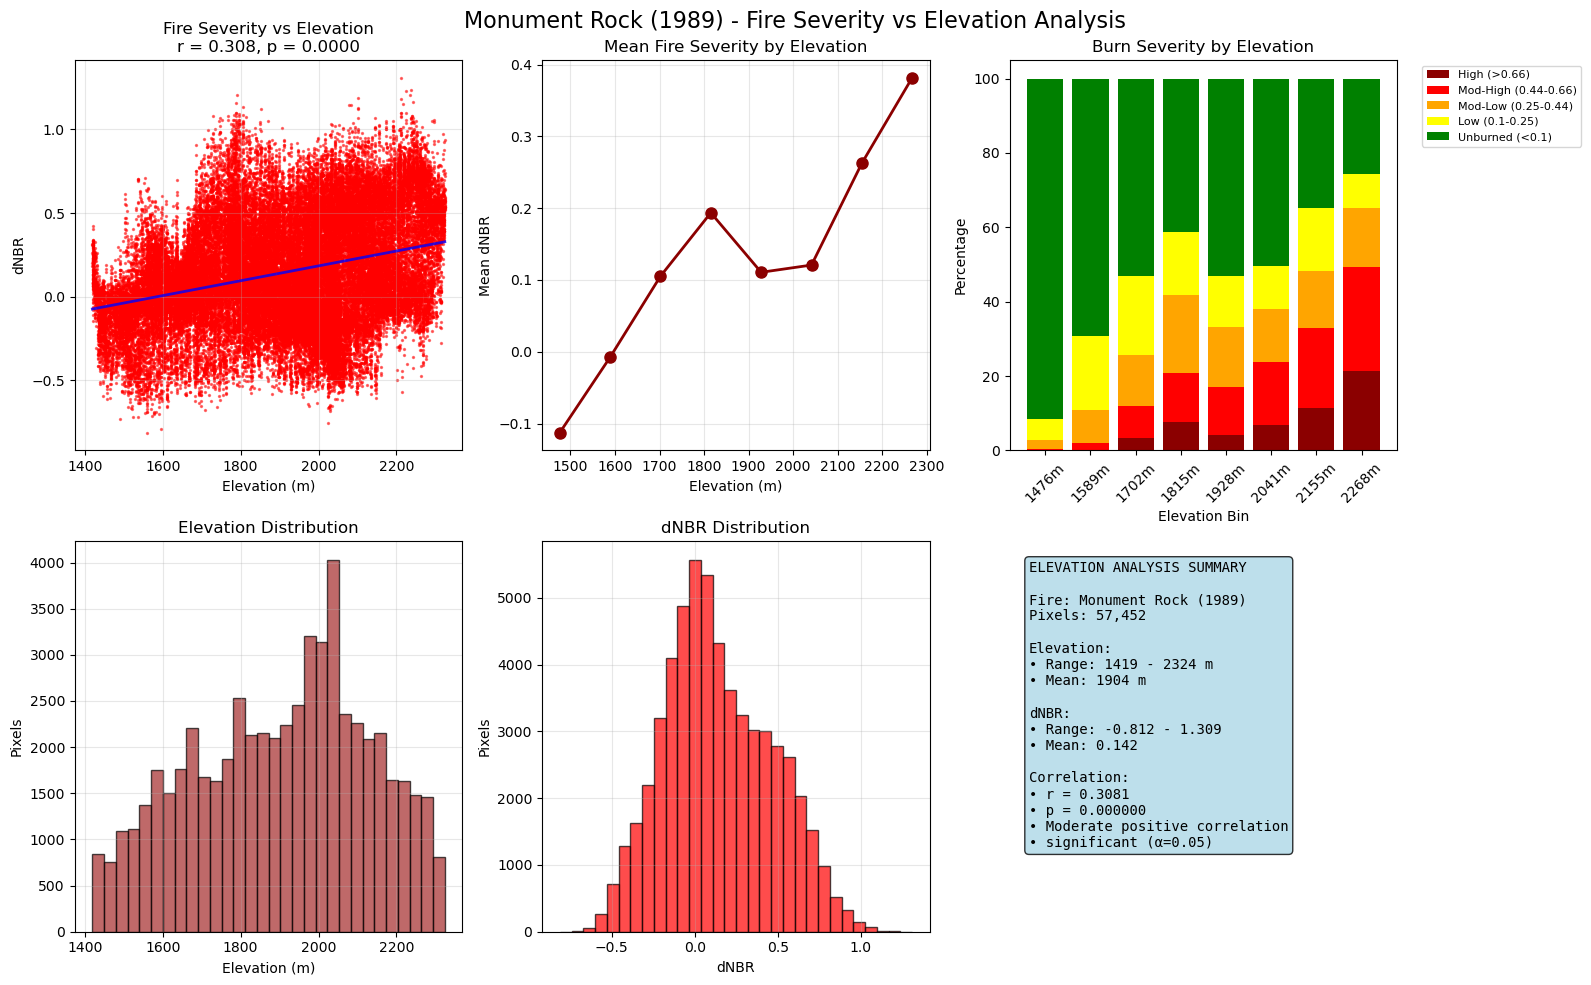


FINAL ANALYSIS RESULTS

Fire Information:
Name: Monument Rock
ID: 1989-ORWWF-000377
Year: 1989
Satellite: LANDSAT-5

Spatial Analysis:
Total analyzed pixels: 57,452
Fire area: 0.00575968 square degrees

Elevation Summary:
Range: 1419 - 2324 m
Mean: 1904 m
Relief: 905 m

Fire Severity Summary:
dNBR Range: -0.812 - 1.309
Mean dNBR: 0.142

Elevation-Fire Severity Correlation:
Pearson correlation: 0.3081
P-value: 0.000000
Statistical significance: Yes (α=0.05)

Interpretation:
There is a moderate positive correlation between elevation and fire severity.
Higher elevations experienced more severe burning on average.

Detailed Severity by Elevation Zones:
Elevation (m) Mean dNBR  High Sev %  Mod-High %  Pixels  
-----------------------------------------------------------------
1476         -0.113     0.0         0.4         3521    
1589         -0.007     0.1         1.7         5757    
1702         0.105      3.3         8.7         6819    
1815         0.194      7.7         13.1       

{'fire_info': {'geometry': <POLYGON ((-118.255 44.33, -118.255 44.33, -118.255 44.33, -118.255 44.33, -...>,
  'fire_id': '1989-ORWWF-000377',
  'incident_name': 'Monument Rock',
  'fire_year': 1989,
  'index': 0},
 'pre_fire_nbr': <xarray.DataArray (band: 1, y: 362, x: 268)> Size: 776kB
 dask.array<getitem, shape=(1, 362, 268), dtype=float64, chunksize=(1, 362, 153), chunktype=numpy.ndarray>
 Coordinates:
   * band         (band) int64 8B 1
   * x            (x) float64 2kB 3.948e+05 3.949e+05 ... 4.028e+05 4.028e+05
   * y            (y) float64 3kB 4.916e+06 4.916e+06 ... 4.905e+06 4.905e+06
     spatial_ref  int64 8B 0,
 'post_fire_nbr': <xarray.DataArray (band: 1, y: 362, x: 268)> Size: 776kB
 dask.array<getitem, shape=(1, 362, 268), dtype=float64, chunksize=(1, 362, 165), chunktype=numpy.ndarray>
 Coordinates:
   * band         (band) int64 8B 1
   * x            (x) float64 2kB 3.948e+05 3.949e+05 ... 4.028e+05 4.028e+05
   * y            (y) float64 3kB 4.916e+06 4.916e+06 ... 

In [5]:
run_fire_elevation_analysis('../downloaded_data/mnf_fires_all.geojson', 1989, 0)